In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost
import shap
import matplotlib.dates as mdates
from ipynb.fs.full.my_functions import process_data
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

In [2]:
# Save df as pickle
df = process_data()
df.to_pickle("modeling.pkl")

In [2]:
df = pd.read_pickle("modeling.pkl")

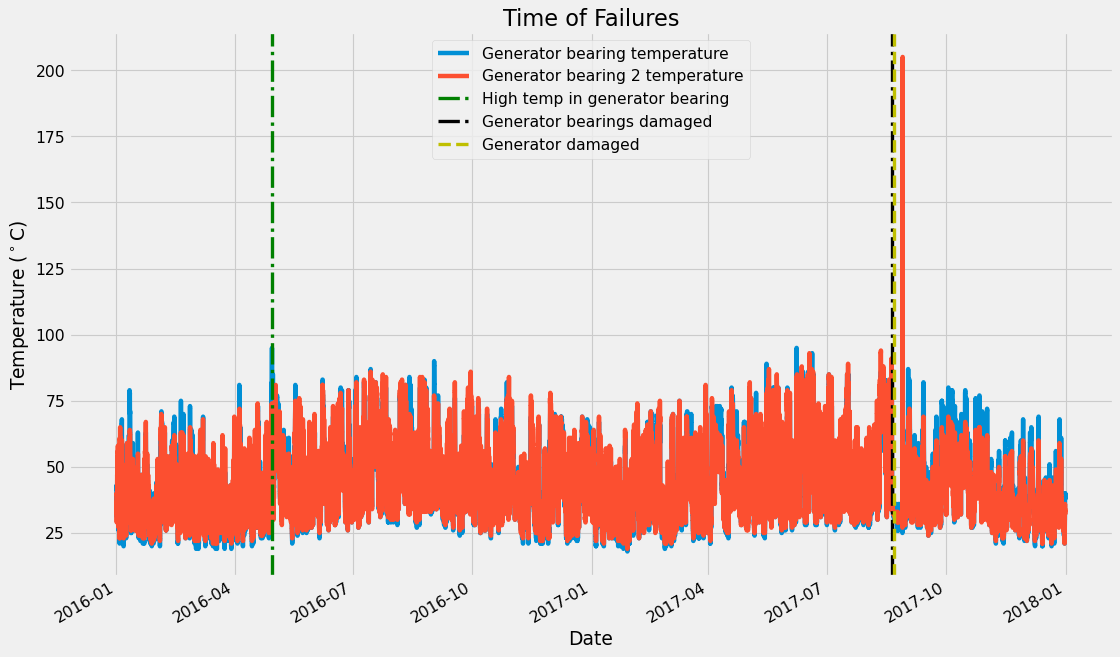

In [3]:
# Define size of plot and styles etc.
time_of_failure = ['2016-04-30 04:40:00', '2017-08-20 08:10:00', '2017-08-21 16:50:00']
fix, ax = plt.subplots(figsize=(15,10), dpi=80)
df.Gen_Bear_Temp.plot(ax=ax, label='Generator bearing temperature', title='Time of Failures')
df.Gen_Bear2_Temp.plot(label='Generator bearing 2 temperature', title='Time of Failures')

# ax.axvline('2017', color='black', ls='--')
# ax.axvline('2017-06', color='black', ls='--')

# Create vertical lines at times of failure
labels = ["High temp in generator bearing", "Generator bearings damaged", "Generator damaged"]
colors = ["g", "black", "y"]
n = 0
for failure in time_of_failure[:2]:
    ax.axvline(failure, label=labels[n], color=colors[n], ls='-.', lw='3')
    n += 1
ax.axvline(time_of_failure[-1], label=labels[-1], color=colors[-1], ls='--', lw='3')

    
ax.legend(['Generator bearing temperature', "Generator bearing 2 temperature", "High temp in generator bearing", "Generator bearings damaged", "Generator damaged"])
ax.set_ylabel('Temperature ($^\circ$C)')
plt.show()

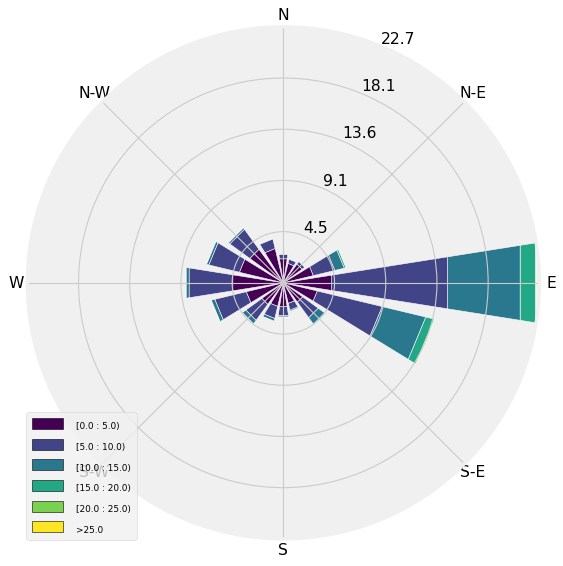

In [4]:
from windrose import WindroseAxes
ax = WindroseAxes.from_ax()
ax.bar(df.Wind_Dir, df.Wind_Speed, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.show()

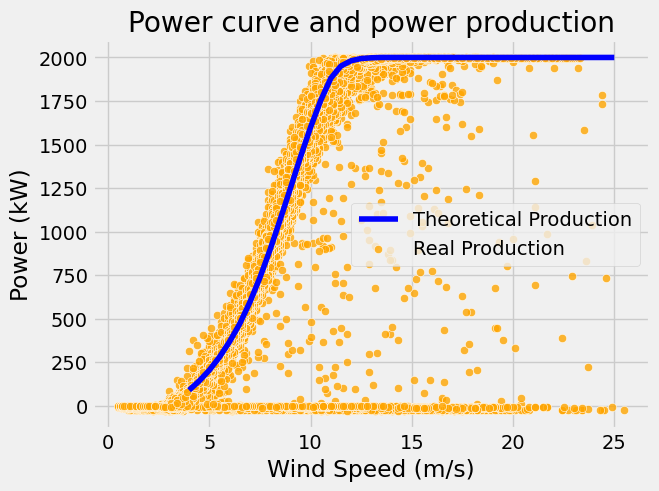

In [3]:
df_powercurve = pd.read_excel('powercurve.xlsx')

#plt.figure(figsize=(12,8), dpi=80)
sns.scatterplot(x=df['Wind_Speed'], y=df['Prod_Pwr'], color='orange', label='Real Production', alpha=0.8)
sns.lineplot(x=df_powercurve['WindSpeed'], y=df_powercurve['Power'], color='blue', label='Theoretical Production')
plt.title('Power curve and power production')
plt.ylabel('Power (kW)');
plt.xlabel('Wind Speed (m/s)');
plt.show()

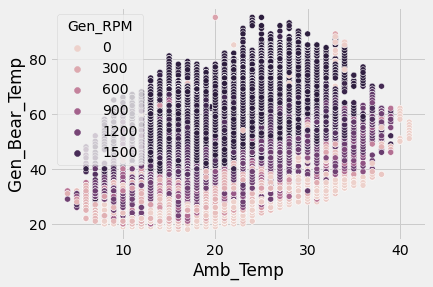

In [7]:
sns.scatterplot(x='Amb_Temp',
                y='Gen_Bear_Temp',
                hue="Gen_RPM",
                data=df)
plt.show()

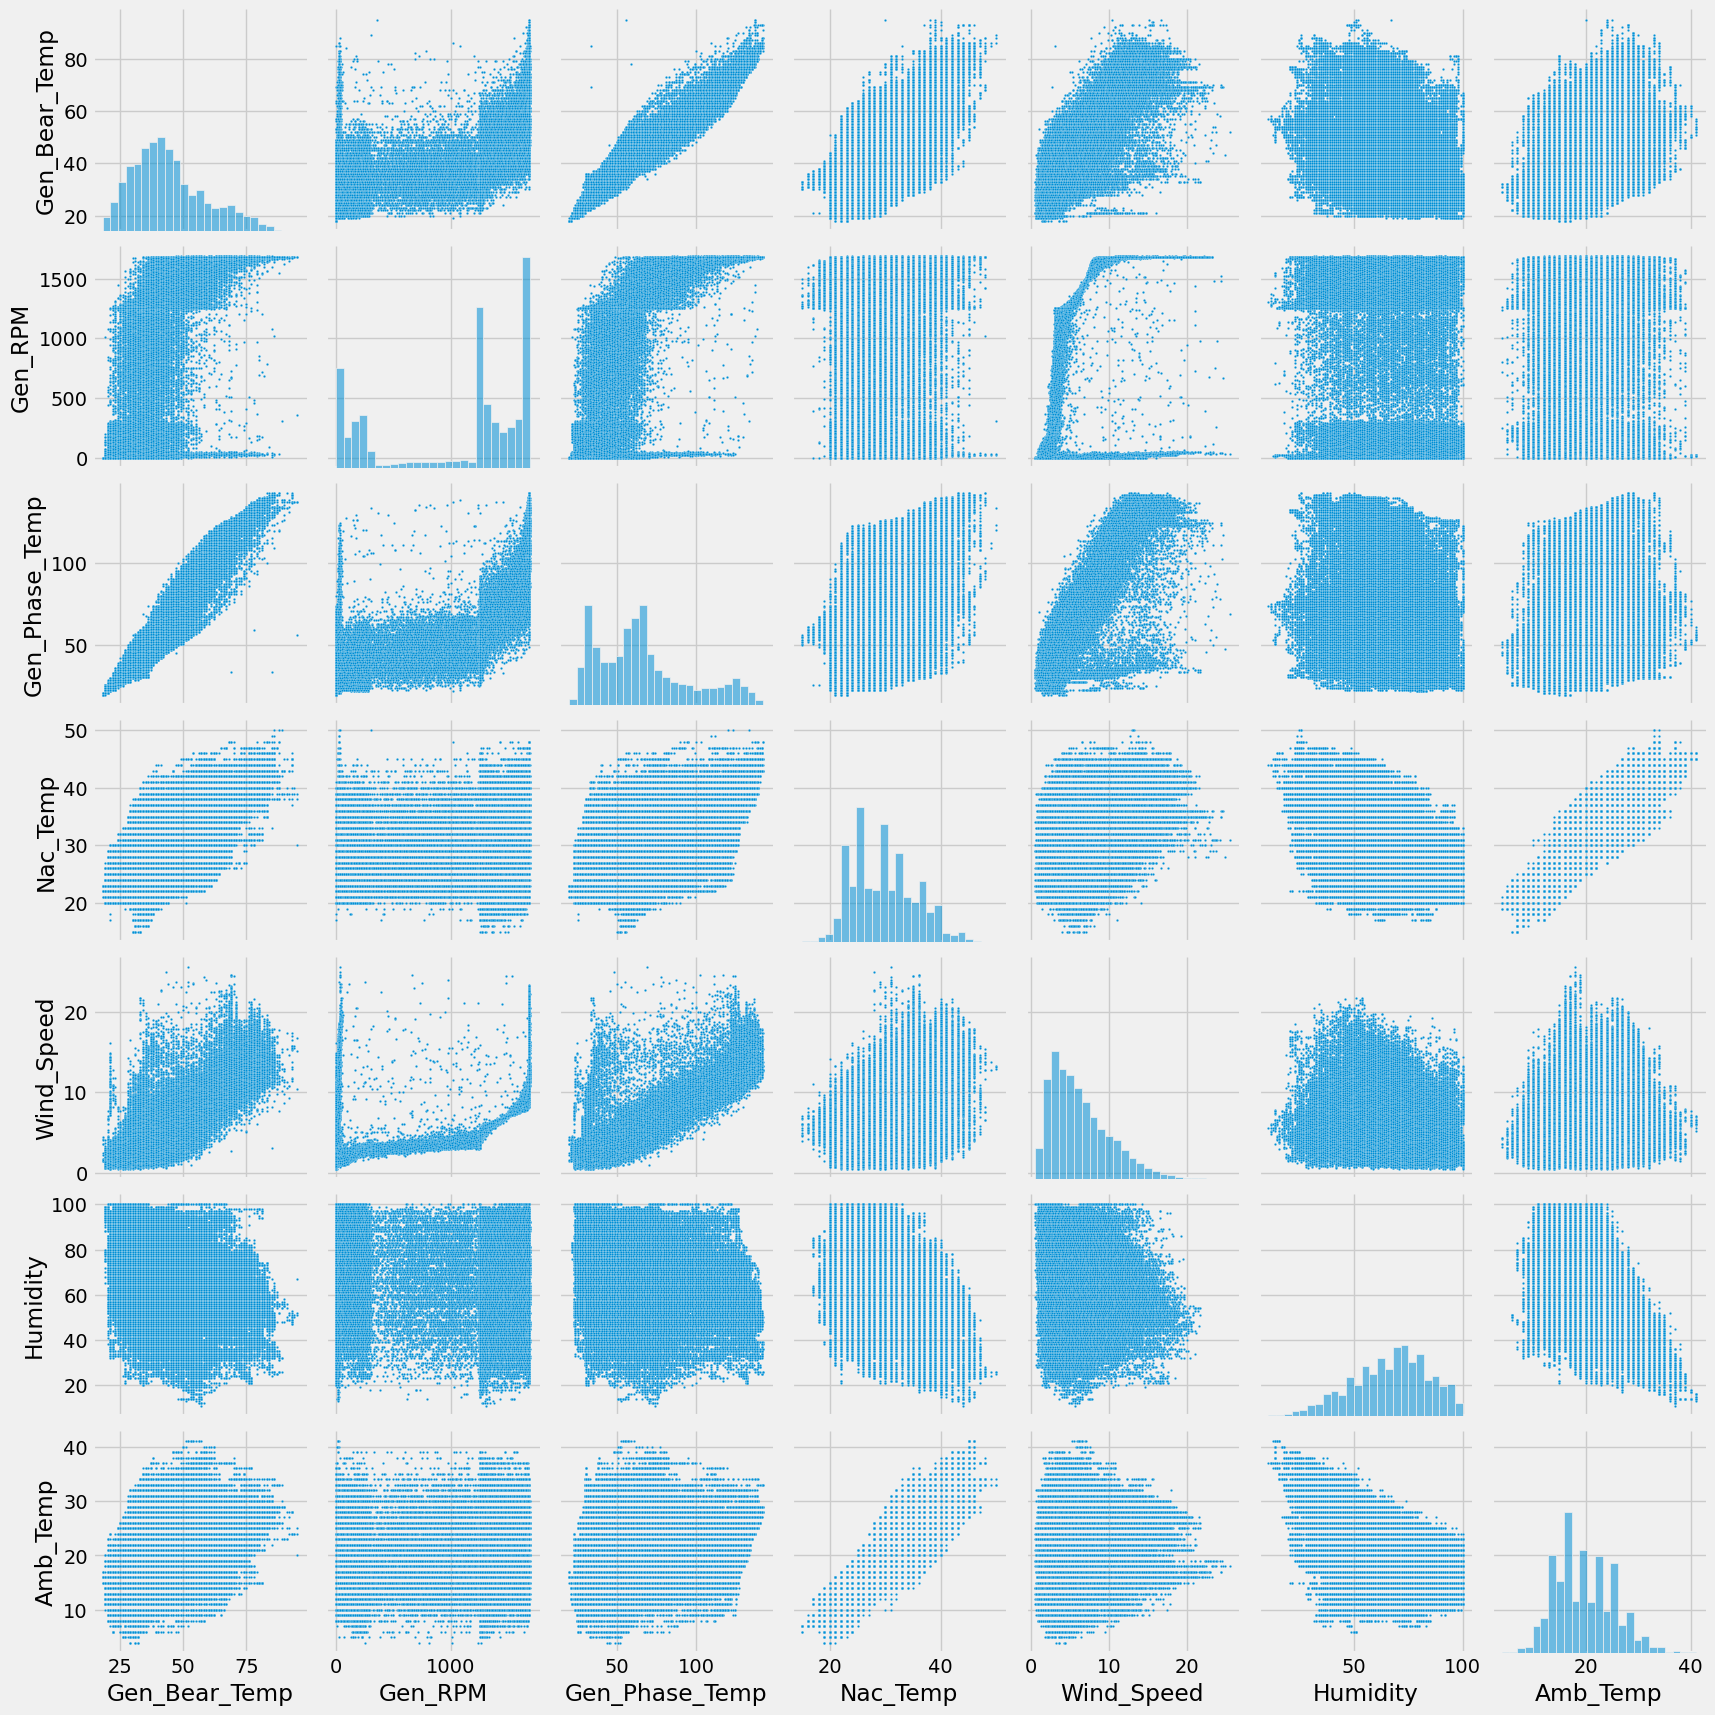

In [8]:
FEATURES = ['Gen_Bear_Temp', 'Gen_RPM', 'Gen_Phase_Temp', 'Nac_Temp', 'Wind_Speed', 'Humidity', 'Amb_Temp']
sns.pairplot(df[FEATURES], diag_kind = "hist",
             diag_kws = {'alpha':0.55, 'bins':25}, plot_kws={"s": 3})
plt.show()

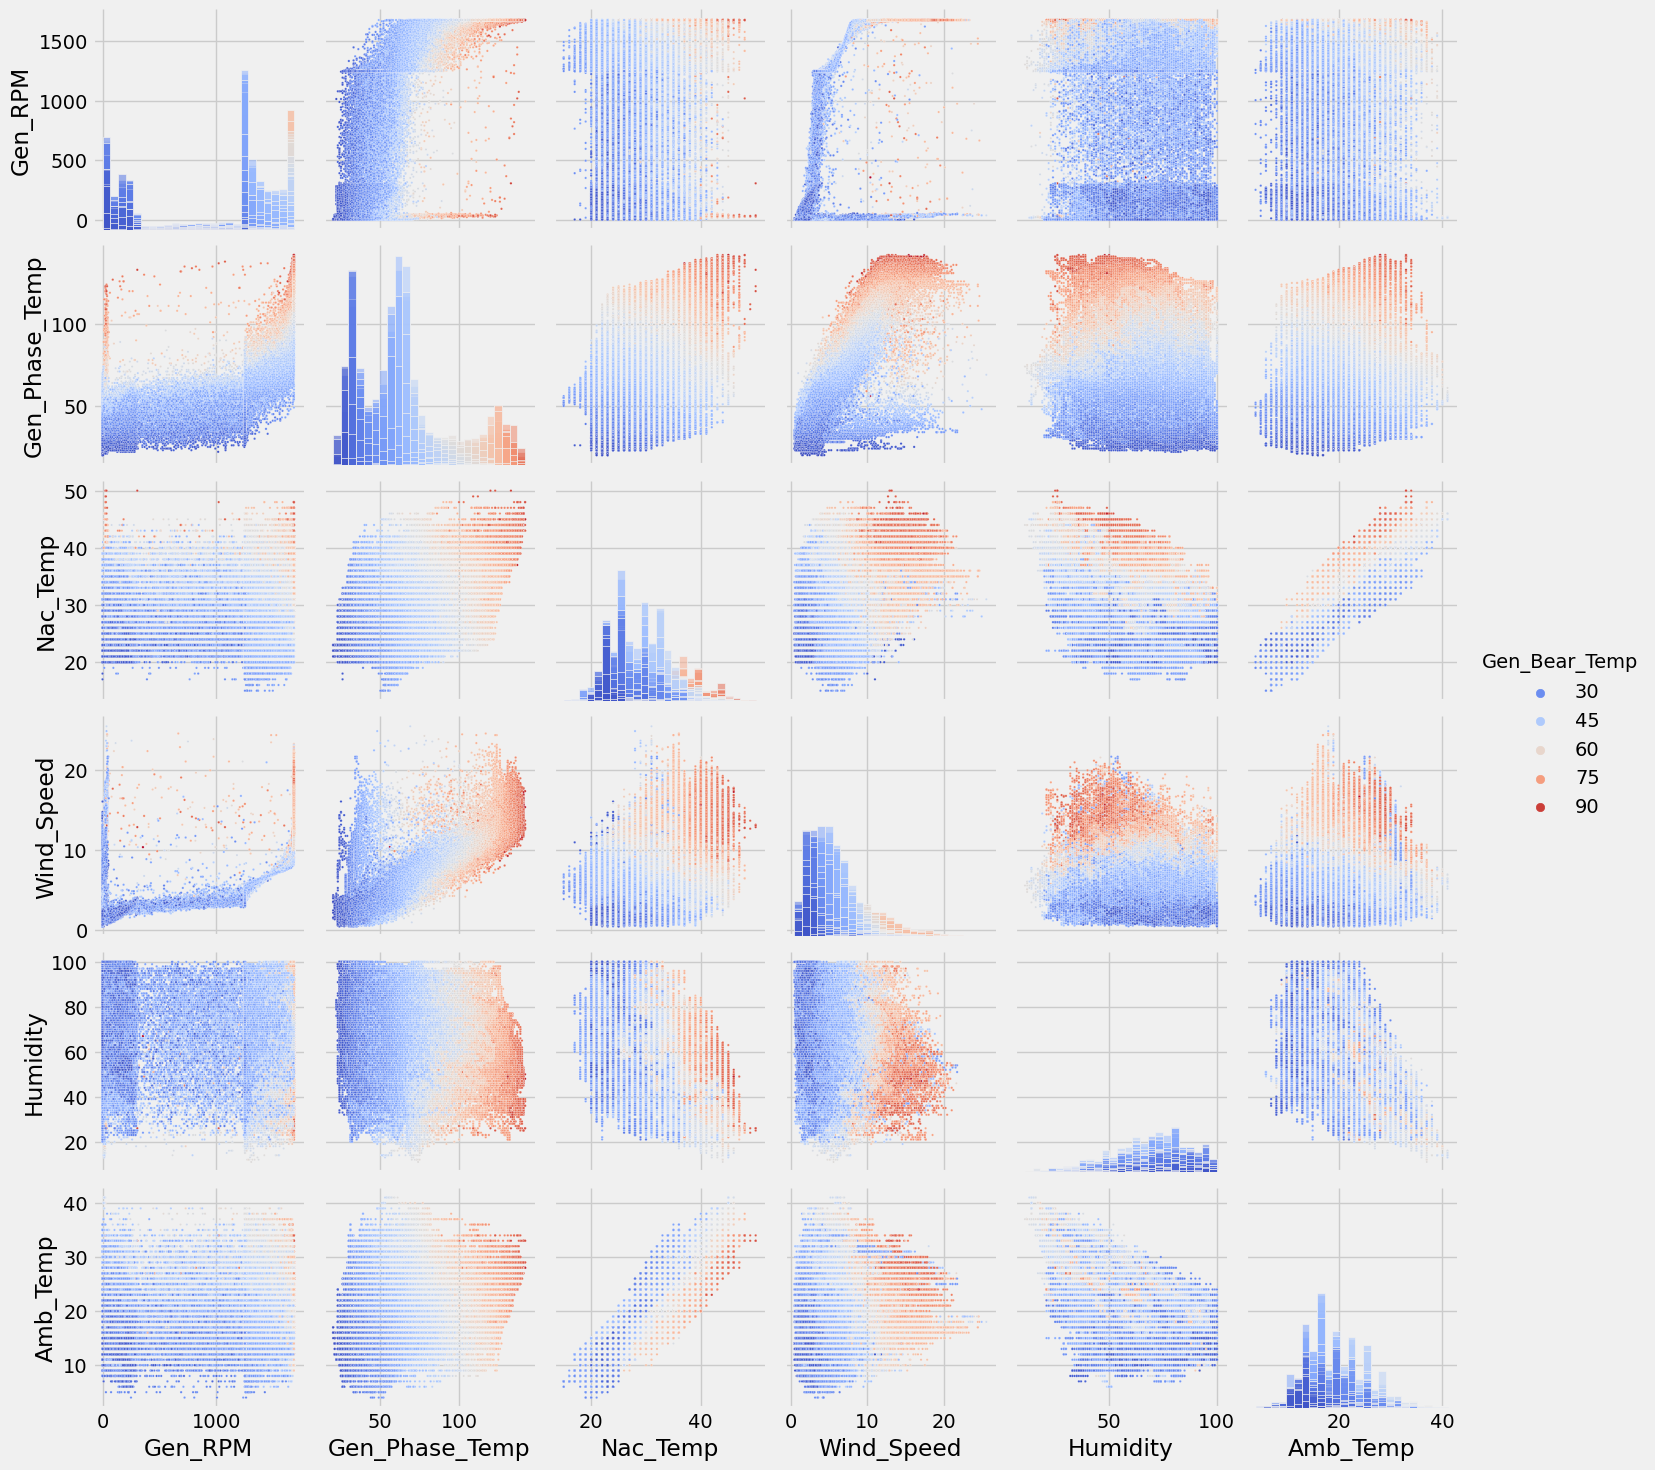

In [7]:
sns.pairplot(df[FEATURES], hue = "Gen_Bear_Temp", diag_kind = "hist", 
             diag_kws = {'alpha':0.55, 'bins':25}, palette = "coolwarm", plot_kws={"s": 3})
plt.show()

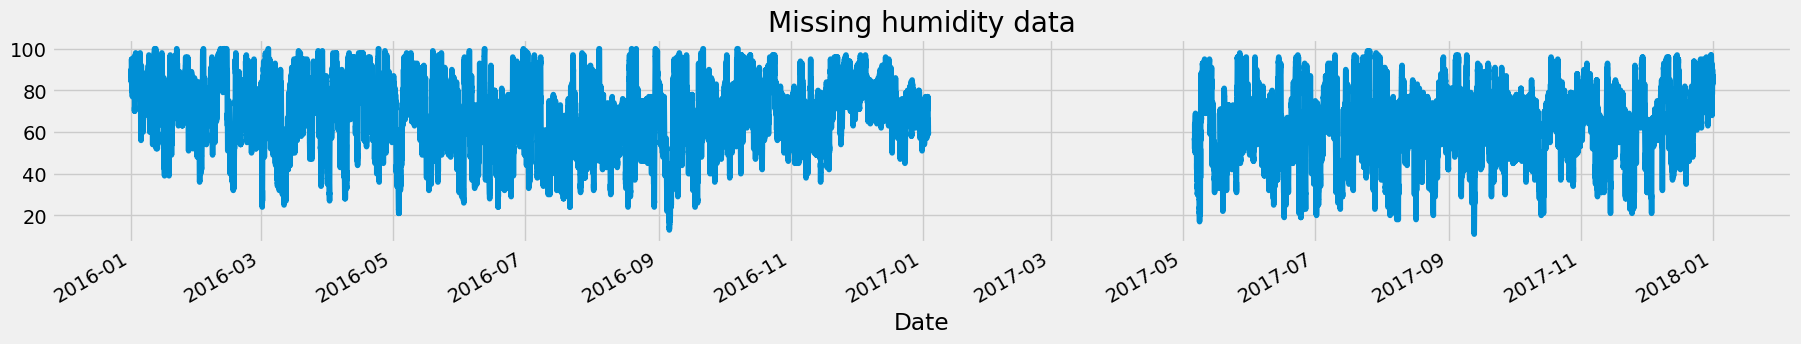

In [26]:
fig, ax = plt.subplots(figsize=(20, 3))
ax = df['Humidity'].plot(ax=ax, title='Missing humidity data')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.show()

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(25,10), dpi=80)
points = ax.scatter(x_test[:, 3], x_test[:, 0], c=test_preds, s=25, cmap=cmap)
f.colorbar(points)
plt.show()

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(25,10), dpi=80)
points = ax.scatter(x_test[:, 3], x_test[:, 0], c=y_test, s=25, cmap=cmap)
f.colorbar(points)
plt.show()

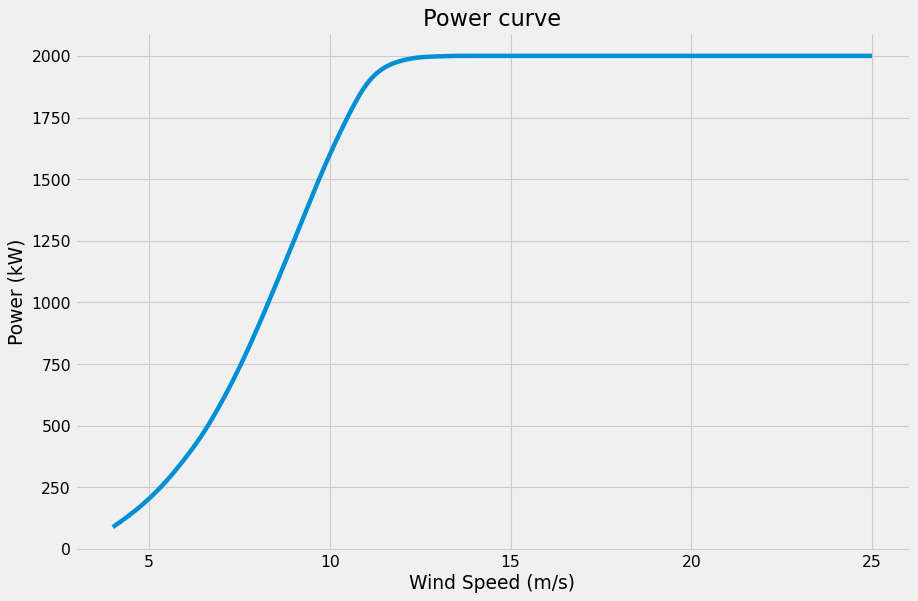

In [32]:
df_powercurve = pd.read_excel('powercurve.xlsx')

# Plot power curve
from scipy.interpolate import make_interp_spline, BSpline
df_pc = pd.read_excel('powercurve.xlsx')

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(df_pc['WindSpeed'].min(), df_pc['WindSpeed'].max(), 300) 

spl = make_interp_spline(df_pc['WindSpeed'], df_pc['Power'], k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.figure(figsize=(12, 8), dpi=80)
plt.plot(xnew, power_smooth)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Power curve')
plt.show()

In [ ]:
# Export df to table in docx
import docx

# open an existing document
doc = docx.Document('./test.docx')

# add a table to the end and create a reference variable
# extra row is so we can add the header row
t = doc.add_table(df_dupl.shape[0]+1, df_dupl.shape[1])

# add the header rows.
for j in range(df_dupl.shape[-1]):
    t.cell(0,j).text = df_dupl.columns[j]

# add the rest of the data frame
for i in range(df_dupl.shape[0]):
    for j in range(df_dupl.shape[-1]):
        t.cell(i+1,j).text = str(df_dupl.values[i,j])

# save the doc
doc.save('./test.docx')

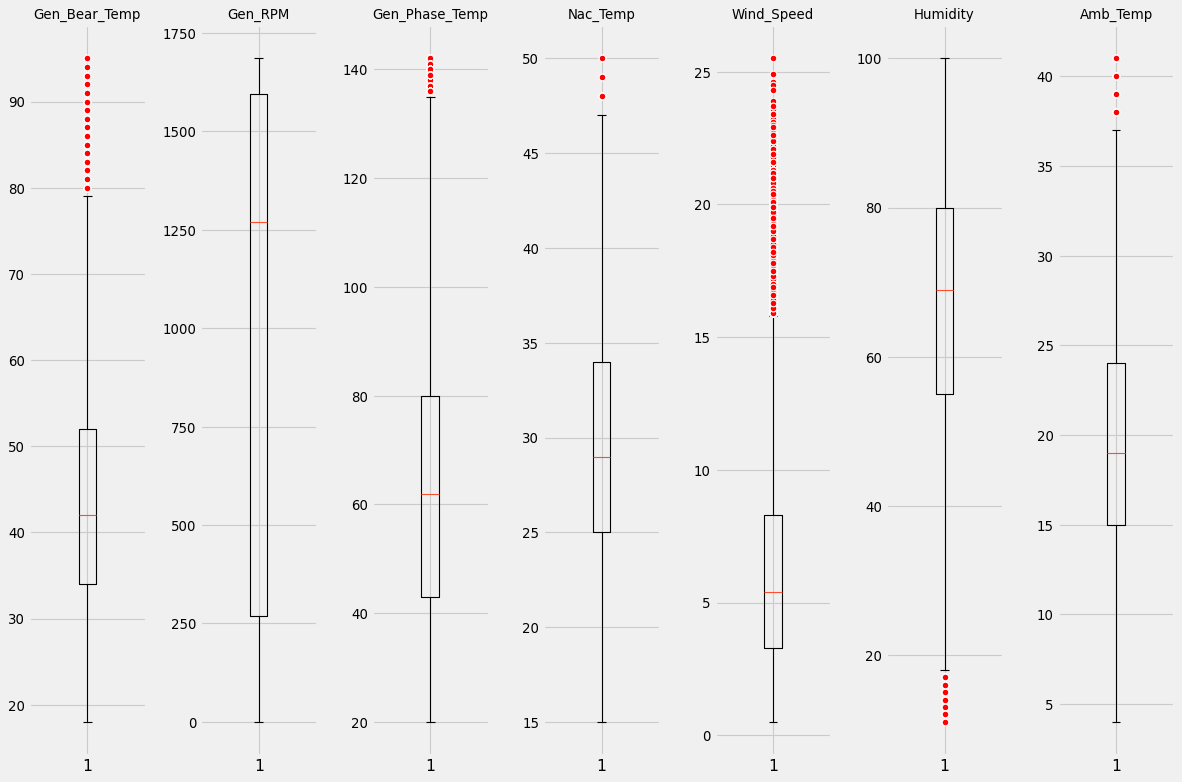

In [27]:
#Creating box plot of each column with its own scale
FEATURES = ['Gen_Bear_Temp', 'Gen_RPM', 'Gen_Phase_Temp', 'Nac_Temp', 'Wind_Speed', 'Humidity', 'Amb_Temp']
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(1, len(df[FEATURES].columns), figsize=(15,10), dpi=80)

for i, ax in enumerate(axs.flat):
    ax.boxplot(df[FEATURES].iloc[:,i].dropna(), flierprops=red_circle)
    ax.set_title(df[FEATURES].columns[i], fontsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
plt.tight_layout()
plt.show()

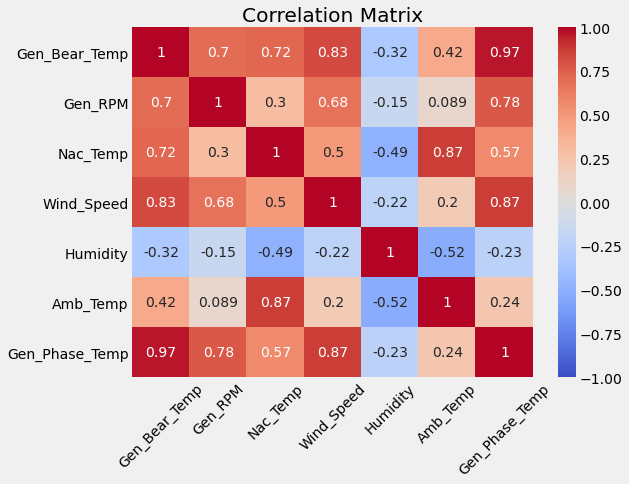

In [10]:
# Correlation matrix
FEATURES = ['Gen_Bear_Temp', 'Gen_RPM', 'Gen_Phase_Temp', 'Nac_Temp', 'Wind_Speed', 'Humidity', 'Amb_Temp']
plt.figure(figsize=(8,6))
corr = df[FEATURES].corr()

heatmap = sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
heatmap.set_title('Correlation Matrix')
plt.xticks(rotation=45)
plt.show()

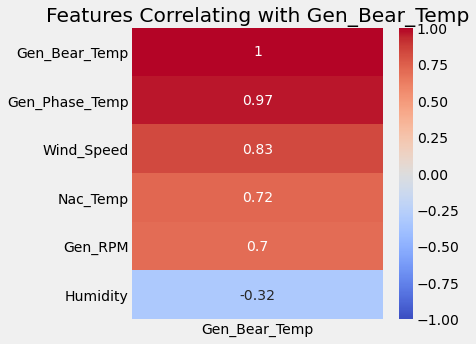

In [56]:
plt.figure(figsize=(5, 5))
heatmap = sns.heatmap(corr[['Gen_Bear_Temp']].sort_values('Gen_Bear_Temp', ascending=False), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Features Correlating with Gen_Bear_Temp');

In [ ]:
ax = df['Gen_RPM'].value_counts().head(10).plot(kind='bar', title='Top Gen_RPM speed')

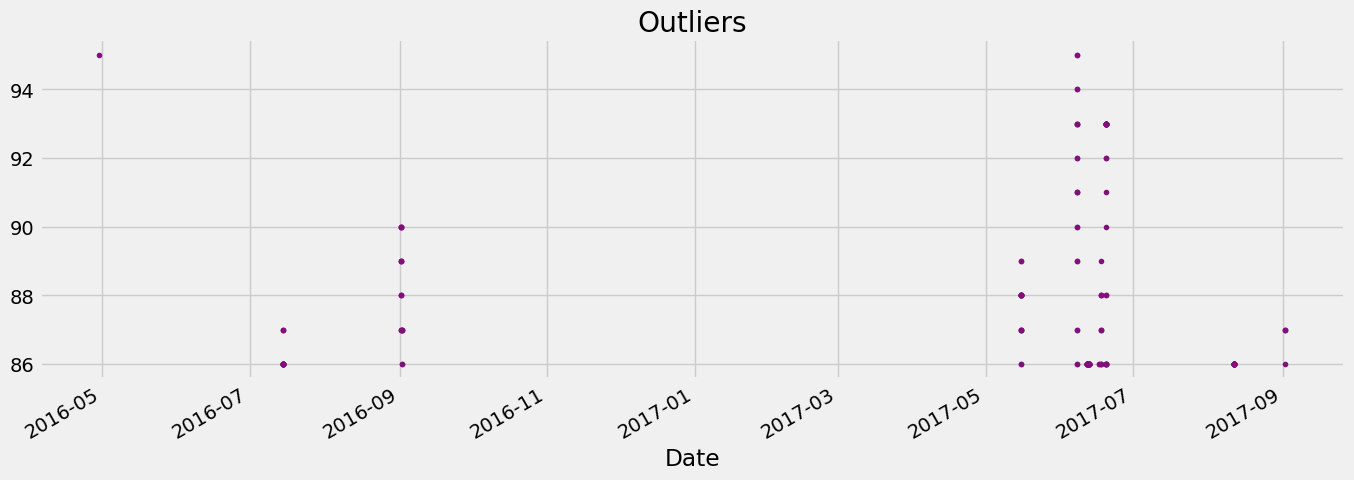

In [31]:
df.query('Gen_Bear_Temp > 85')['Gen_Bear_Temp'].plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')
plt.show()

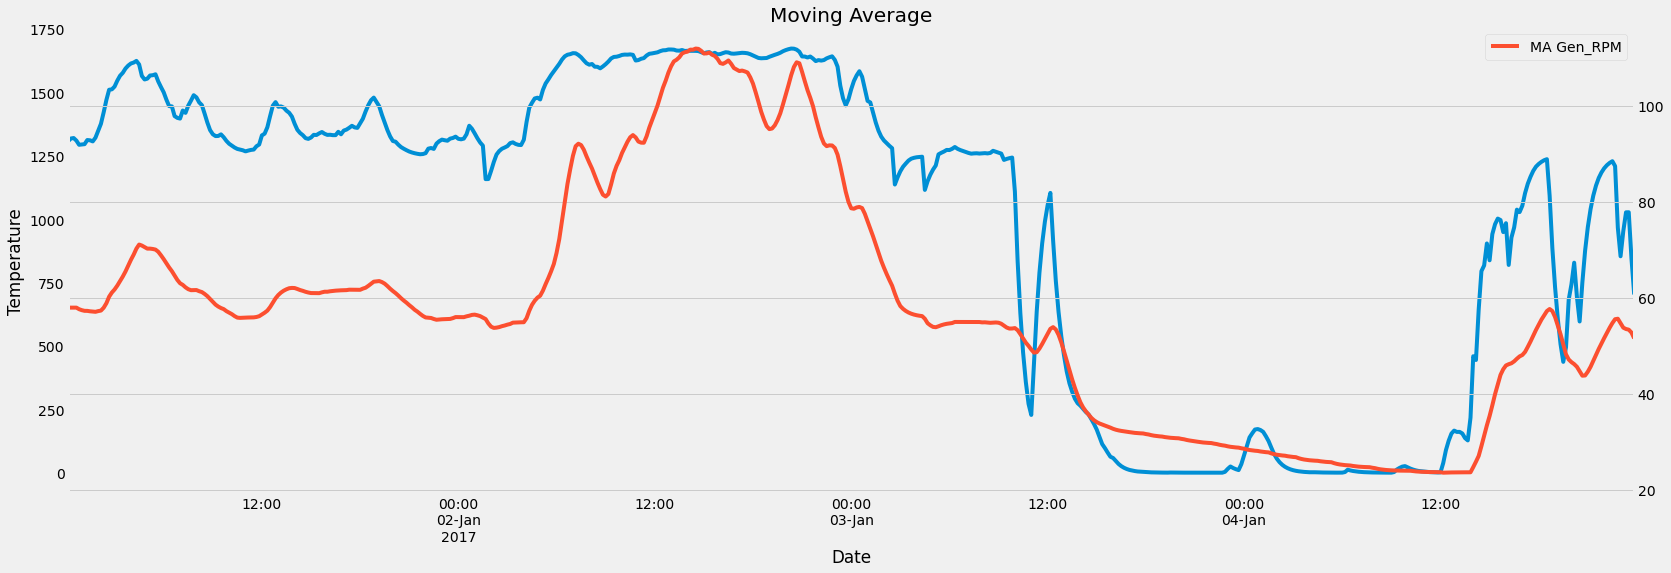

In [35]:
span = 3
freq = '10t'
start = '2017-01-01'
end = '2017-01-05'

#plt.figure(figsize=(25, 8), dpi=80)

fig, ax = plt.subplots(figsize=(25, 8))

ax = df.loc[(df.index > start) & (df.index < end)]['Gen_RPM'].resample(freq).mean().ewm(span).mean() \
    .plot(title='Moving Average', label='MA Gen_RPM', ylabel='Gen RPM')

df.loc[(df.index > start) & (df.index < end)]['Gen_Phase_Temp'].resample(freq).mean().ewm(span).mean() \
    .plot(secondary_y=True, label='MA Gen_Phase_Temp', ylabel='Temperature')

#plt.ylabel('Temperature')
plt.legend(['MA Gen_RPM', 'MA Gen_Phase_Temp'])
plt.show()

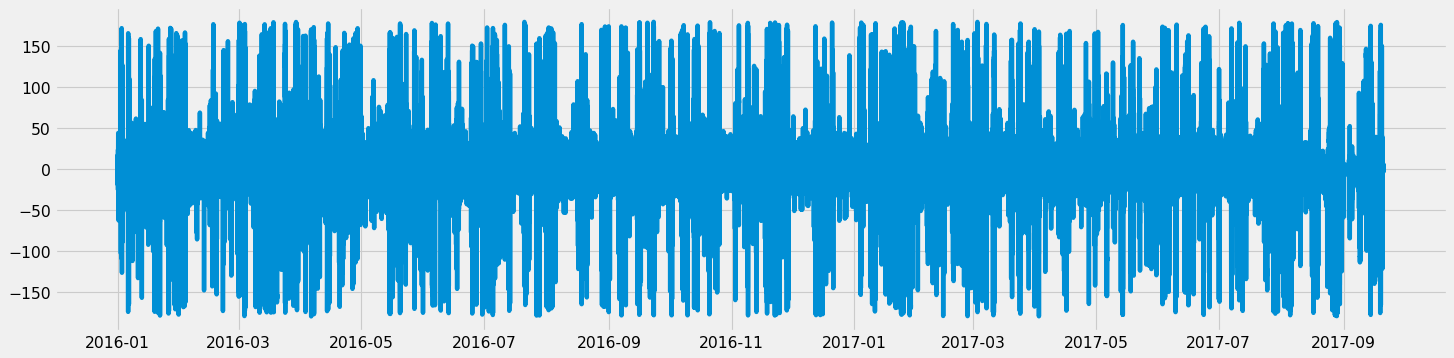

In [44]:
#fig, ax = plt.subplots()
#fig.set(figwidth=8, dpi=100)
#ax.plot(df.index, df['Gen_Phase_Temp'])
plt.figure(figsize=(20, 5), dpi=80)
plt.plot(df.index[:90000], df['Wind_Dir_Rel'][:90000])
plt.show()

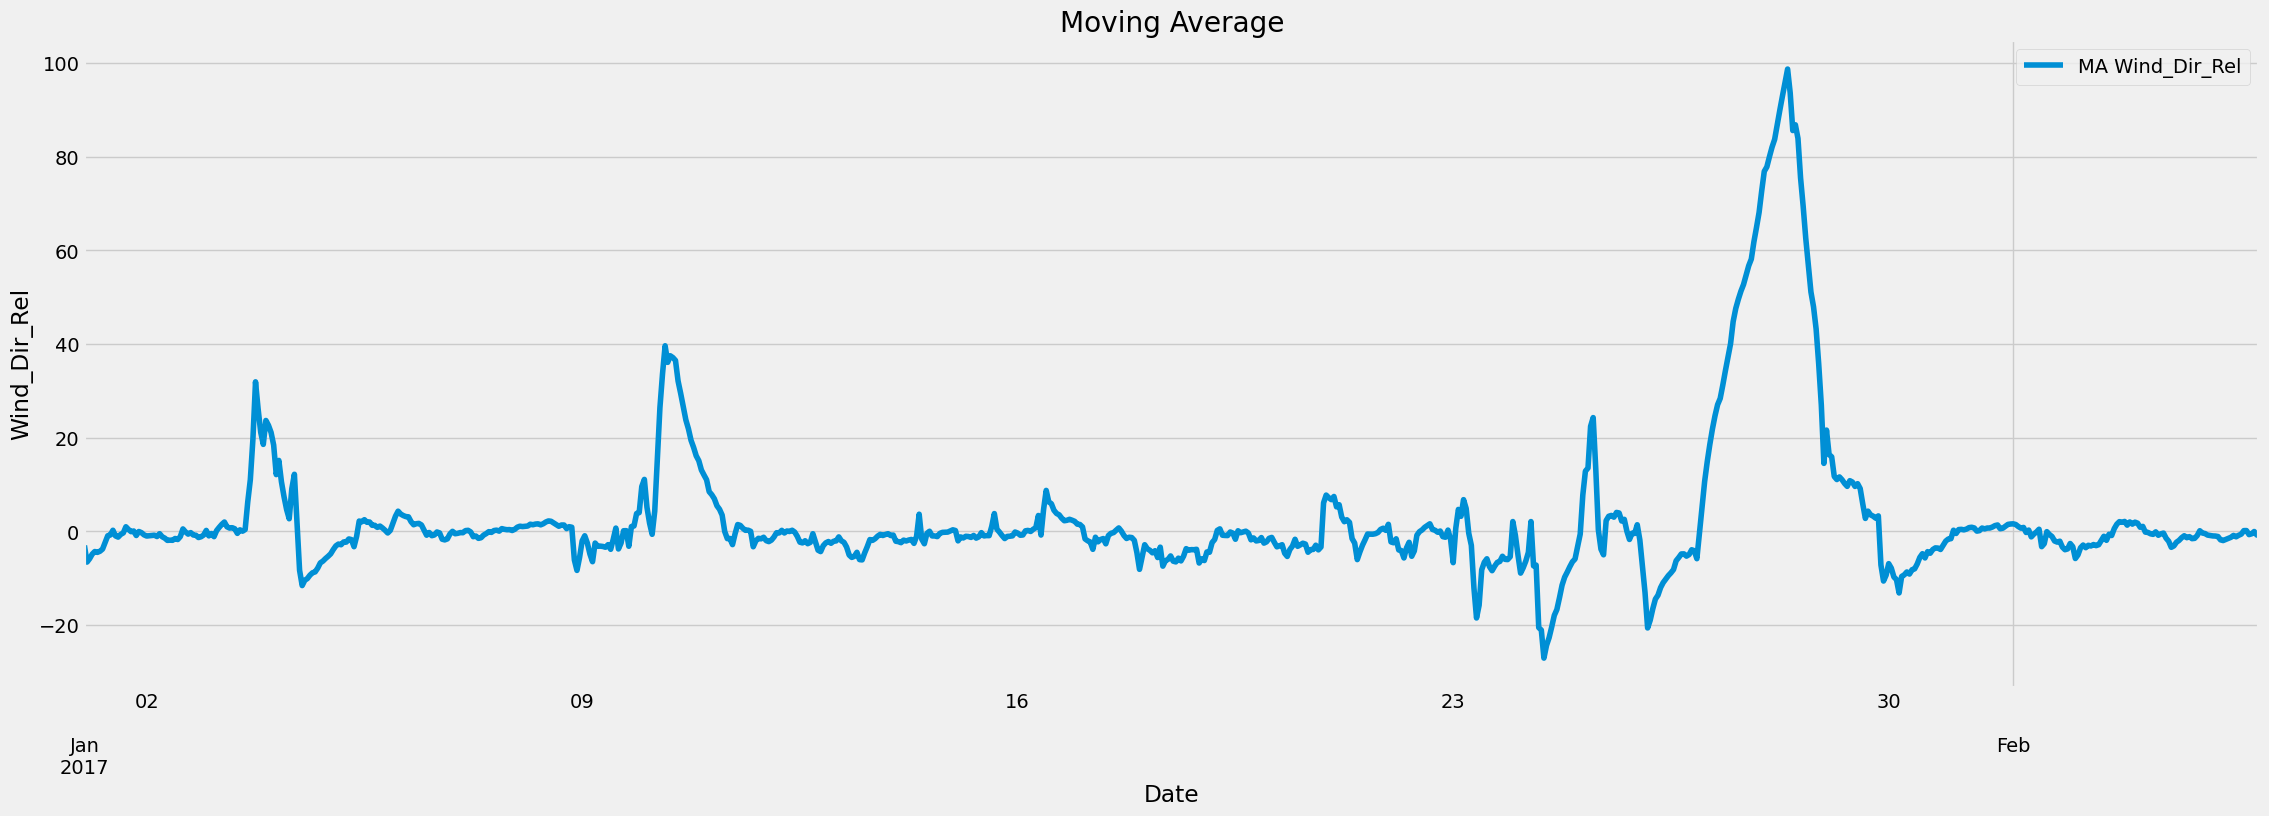

In [49]:
span = 10
freq = '1h'
start = '2017-01-01'
end = '2017-02-05'

#plt.figure(figsize=(25, 8), dpi=80)

fig, ax = plt.subplots(figsize=(25, 8))

ax = df.loc[(df.index > start) & (df.index < end)]['Wind_Dir_Rel'].resample(freq).mean().ewm(span).mean() \
    .plot(title='Moving Average', label='MA Wind_Dir_Rel', ylabel='Wind_Dir_Rel')

plt.legend()
plt.show()